## Laden der Text Daten 

In [3]:
import os
import pandas as pd
import numpy as np
import urllib.request

DATADIR = "data"

if not os.path.exists(DATADIR): 
    os.mkdir(DATADIR)

file_name = os.path.join(DATADIR, "17-Bundestag.csv")
if not os.path.exists(file_name):
    url_data = 'https://www.dropbox.com/s/i4lp1fidpbo3k1w/17-Bundestag.csv?dl=1'
    urllib.request.urlretrieve(url_data, file_name)

df = pd.read_csv(file_name)

print("{} Reden wurden geladen".format(len(df)))

# Zeige einige Reden von Parteien
for party in np.unique(df['partei']):
    print("\n****************************\nBeispiele von Partei {}:\n****************************\n".format(party))
    for _, speech in df[df['partei']==party].sample(2).iterrows():
        print("\n*******************************\nSprecher {}:\n\n{}".format(speech['sprecher'], speech['text']))


57636 Reden wurden geladen

****************************
Beispiele von Partei cducsu:
****************************


*******************************
Sprecher Maria Michalk:

Im Gesetzentwurf der Fraktion Die Linke wird gefordert, die aktuell geltenden Fristen für die Feststellung der Schwerbehinderteneigenschaft von Menschen mit einer oder mehrfachen Behinderungen, die erwerbstätig sind, auf alle Feststellungen der Schwerbehinderteneigenschaft auszudehnen.

In der Tat erreichen uns immer wieder Beschwerden über zu lange Bearbeitungszeiten. Auch ich kenne -Beispiele, wo die Entscheidung erst nach 14 oder 15 Wochen den Antragsteller erreicht hat. Das ist für die -Betroffenen kaum akzeptabel; denn der Schwerbehindertenausweis ist als Nachweis notwendig, um Nachteilsausgleichsregelungen in Anspruch nehmen zu können. So ist zum Beispiel auch die Inanspruchnahme des besonderen Kündigungsschutzes von der Vorlage der Schwerbehindertenbestätigung kausal abhängig.

Die Initiatoren des Gesetzentw

In [19]:
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import SGDClassifier
from sklearn.pipeline import Pipeline
import warnings

def train(texts, party):
    '''
    Eine Funktion, die gegeben Texte und Labels einen Klassifier trainiert
    '''
    with warnings.catch_warnings():
        warnings.simplefilter("ignore")
        # Eine Machine Learning Pipeline um Bag-of-Words Vectors zu erstellen aus Texten
        text_clf = Pipeline([('vect', CountVectorizer(ngram_range=(1,1), max_df=0.5)),
                            ('clf', SGDClassifier(loss='log'))])
        text_clf.fit(texts,party)

    return text_clf


## Trainieren eines linearen Klassifiers

In [20]:
# Erst nehmen wir einige Daten beiseite, um das Model darauf spaeter testen zu koennen
train_data, test_data, train_labels, test_labels = train_test_split(df['text'], df['partei'], test_size=0.2)

# Jetzt trainieren wir den Klassifier
clf = train(df['text'], df['partei'])

## Performance auf Test Daten

In [21]:
test_predictions = clf.predict(test_data)
report = classification_report(test_predictions, test_labels)
print(report)

             precision    recall  f1-score   support

     cducsu       0.83      0.83      0.83      3361
        fdp       0.73      0.76      0.75      1619
     gruene       0.88      0.63      0.73      2488
      linke       0.81      0.85      0.83      1699
        spd       0.69      0.85      0.76      2361

avg / total       0.79      0.78      0.78     11528



## Confusion Matrix

In [22]:
print(confusion_matrix(test_labels, test_predictions))

[[2791  175  203   70  134]
 [ 215 1238  139   31   70]
 [  54   38 1569   40   86]
 [  65   26  185 1449   69]
 [ 236  142  392  109 2002]]


## Download eines Zeitungsartikels

In [23]:
import urllib.request
from readability.readability import Document

url = "http://www.spiegel.de/politik/ausland/muss-deutschland-jetzt-milliarden-an-polen-zahlen-a-1167144.html"
html = urllib.request.urlopen(url).read()
readable_article = Document(html).summary()
readable_title = Document(html).short_title()


## Klassifizierung des Zeitungsartikels

Zeitungsartikel: Muss Deutschland jetzt Milliarden an Polen zahlen?


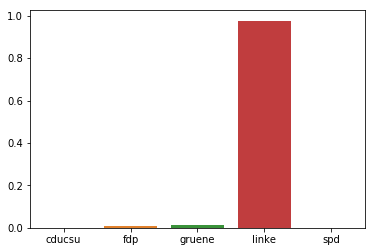

In [40]:
prediction = clf.predict_proba([readable_article])

print("Zeitungsartikel: {}".format(readable_title))

import seaborn as sns
%matplotlib inline
sns.barplot(clf.steps[1][1].classes_, prediction.flatten())

In [18]:
bow_vectors = clf.steps[0][1].transform(df.text)
idx2words = {k:v for v,k in clf.steps[0][1].vocabulary_.items()}
for party in np.unique(df['partei']):
    this_party = (df['partei'] == party).values * 2 - 1
    word_covariance = bow_vectors.T.dot(this_party).argsort()
    top_words = [idx2words[widx] for widx in word_covariance[-20:][::-1]]
    print("*********************\nPartei {} benutzt haeufig:\n{}".format(party, ", ".join(top_words)))

*********************
Partei cducsu benutzt haeufig:
christlich, verehrten, kernenergie, dankbar, christen, wettbewerbsfähigkeit, währung, mitbürger, unionsgeführte, wiedervereinigung, übergabe, zusammenfassend, deutlichkeit, lauterbach, mitbürgerinnen, schick, nettokreditaufnahme, gottes, vorrednern, finanzmarkt
*********************
Partei fdp benutzt haeufig:
liberaler, zuwanderer, zuwanderungssteuerung, zuwanderungspolitik, pflanzenzüchtung, zeitarbeiter, bereicherten, willkommens, beschäftigungsformen, geschätzter, bankenrestrukturierungsgesetz, zwangsquote, tarifausschuss, wissenschaftlers, wisszeitvg, rechtshistoriker, eingliederungsbudget, allgäuer, hefen, splittingtarif
*********************
Partei gruene benutzt haeufig:
garantierente, leiharbeitskräfte, baustoffe, bäuerliche, einwanderinnen, agrarindustrie, immigranten, einwanderer, menschenrechtskriterien, bündnisgrüne, rekordverschuldung, ewi, platzes, kill, aggressionsverbrechens, rüstungsexportrichtlinie, optionszwang, a